In [1]:
import pickle

import genjax
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import rerun as rr
import trimesh
from genjax import Pytree

import b3d
import b3d.bayes3d as bayes3d
import b3d.chisight.dense.dense_model
from b3d import Mesh, Pose
from b3d.chisight.dense.likelihoods.laplace_likelihood import likelihood_func
from b3d.utils import rotation_from_axis_angle

with open('09-22-2024-17:10:49.pkl', 'rb') as f:
    data = pickle.load(f)


In [2]:
font = {#'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

In [3]:
def _enumerate_and_get_scores(trace, addressses, all_deltas):
    addr = addressses.unwrap()[0]
    current_pose = trace.get_choices()[addr]
    scores_list = []
    for i in range(len(all_deltas)):
        test_poses = current_pose @ all_deltas[i]
        scores = b3d.enumerate_choices_get_scores(
            trace, addressses, test_poses
        )
        scores_list.append(scores)
    return jnp.array(scores_list)


enumerate_and_get_scores = jax.jit(
    _enumerate_and_get_scores, static_argnames=["addressses"]
)

In [4]:
def get_hyperparams(frame_name):
    xy_cbar_min, xy_cbar_max = -12.5, -4
    theta_bar_min, theta_bar_max = -8.0, -6.0
    if frame_name == 't0_yellow':
        frame = 0
        obj_pose = Pose(jnp.array([0.3063635 , 0.07456876, 0.70654905]), jnp.array([-0.6930068 ,  0.69431657, -0.13396354, -0.14042774]))
        mesh_path = 'GEABP1.0-60-10-B-10_Gear_60teeth.stl'
        pix_color = jnp.array([0.845, 0.751, 0.162])
        xtheta_cbar_min, xtheta_cbar_max = theta_bar_min, theta_bar_max
        ytheta_cbar_min, ytheta_cbar_max = theta_bar_min, theta_bar_max
    
    elif frame_name == 't0_blue':
        frame = 0
        obj_pose = Pose(jnp.array([0.36641008, -0.18363556,  0.8124013]), jnp.array([0.69423044,  0.69290215, -0.14094163,  0.13441093]))
        mesh_path = 'GEABP1.0-20-10-B-10_Gear_20teeth.stl'
        pix_color = jnp.array([0, 0.4265, 0.6128])
        # jnp.array([18/256.0, 104/256.0, 151/256.0])
        xtheta_cbar_min, xtheta_cbar_max = theta_bar_min, theta_bar_max
        ytheta_cbar_min, ytheta_cbar_max = theta_bar_min, theta_bar_max
    
    elif frame_name == 't0_pink':
        frame = 0
        obj_pose = Pose(jnp.array([0.28745207, -0.05617312,  0.7600653]), jnp.array([0.69455296,  0.69301903, -0.14033823,  0.13276304]))
        mesh_path = 'GEABP1.0-40-10-B-10_Gear_40teeth.stl'
        pix_color = jnp.array([0.684, 0.274, 0.44])
        xtheta_cbar_min, xtheta_cbar_max = theta_bar_min, theta_bar_max
        ytheta_cbar_min, ytheta_cbar_max = theta_bar_min, theta_bar_max
    
    elif frame_name == 'close_yellow':
        frame = 1
        obj_pose = Pose(jnp.array([ 0.04625247, -0.02085921,  0.21470283]), jnp.array([ 0.70640105,  0.7072129 ,  0.00765728, -0.02808588]))
        mesh_path = 'GEABP1.0-60-10-B-10_Gear_60teeth.stl'
        pix_color = jnp.array([0.845, 0.751, 0.162])
        xtheta_cbar_min, xtheta_cbar_max = theta_bar_min, theta_bar_max
        ytheta_cbar_min, ytheta_cbar_max = theta_bar_min, theta_bar_max
    
    elif frame_name == 'close_blue':
        frame = 3
        obj_pose = Pose(jnp.array([0.04 , 0.   , 0.191]), jnp.array([ 7.071068e-01,  7.071068e-01, -3.090862e-08, -3.090862e-08]))
        mesh_path = 'GEABP1.0-20-10-B-10_Gear_20teeth.stl'
        pix_color = jnp.array([0, 0.4265, 0.6128])
        xtheta_cbar_min, xtheta_cbar_max = theta_bar_min, theta_bar_max
        ytheta_cbar_min, ytheta_cbar_max = theta_bar_min, theta_bar_max
    
    elif frame_name == 'close_pink':
        frame = 5
        obj_pose = Pose(jnp.array([ 0.02 , -0.03 ,  0.188]), jnp.array([ 0.7071068, -0.7071068,  0.       ,  0.       ]))
        mesh_path = 'GEABP1.0-40-10-B-10_Gear_40teeth.stl'
        pix_color = jnp.array([0.684, 0.274, 0.44])
        xtheta_cbar_min, xtheta_cbar_max = theta_bar_min, theta_bar_max
        ytheta_cbar_min, ytheta_cbar_max = theta_bar_min, theta_bar_max

    return frame, obj_pose, mesh_path, pix_color, xy_cbar_min, xy_cbar_max, xtheta_cbar_min, xtheta_cbar_max, ytheta_cbar_min, ytheta_cbar_max


In [5]:
def get_rotation_poses(num_rotations):
    rot_pose_generator = jax.vmap(lambda theta: Pose.from_pos_matrix(jnp.zeros(3), rotation_from_axis_angle(jnp.array([0,0,1]), theta)), 0)
    return rot_pose_generator(jnp.linspace(-jnp.pi, jnp.pi,num_rotations))


In [6]:
downsample_factor = 2 #1
scaling_factor = 1.0/downsample_factor
intrinsics_frame = 0
camera_mat = data[intrinsics_frame]['camera_image']['camera_matrix'][0]
rgb_intrinsics_frame = data[intrinsics_frame]['camera_image']['rgbPixels']/255.0\

width = rgb_intrinsics_frame.shape[1]
height = rgb_intrinsics_frame.shape[0]
fx = camera_mat[0,0]
fy = camera_mat[1,1]
cx = camera_mat[0,2]
cy = camera_mat[1,2]
near = 0.001
far = 16.0

renderer = b3d.renderer.renderer_original.RendererOriginal(
    width * scaling_factor,
    height * scaling_factor,
    fx * scaling_factor,
    fy * scaling_factor,
    cx * scaling_factor,
    cy * scaling_factor,
    0.01,
    20.0,
)

model, viz_trace, info_from_trace = (
        b3d.chisight.dense.dense_model.make_dense_multiobject_model(
            renderer, likelihood_func
        )
    )
importance_jit = jax.jit(model.importance)

/home/esli/b3d/.pixi/envs/gpu/lib/python3.12/site-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [7]:
likelihood_args = {
    "fx": renderer.fx,
    "fy": renderer.fy,
    "cx": renderer.cx,
    "cy": renderer.cy,
    "image_width": Pytree.const(renderer.width),
    "image_height": Pytree.const(renderer.height),
}

refinement_x_num_points, refinement_y_num_points = 45, 45
refinement_rotation_deltas = get_rotation_poses(refinement_x_num_points*refinement_y_num_points)
refinement_x_grid = jnp.linspace(-0.025, 0.025, refinement_x_num_points)
refinement_y_grid = jnp.linspace(-0.025, 0.025, refinement_y_num_points)
refinement_translation_deltas = jax.vmap(lambda p: Pose.from_translation(p))(
            jnp.stack(
                jnp.meshgrid(
                    refinement_x_grid,
                    refinement_y_grid,
                    jnp.linspace(0, 0, 1),
                ),
                axis=-1,
            ).reshape(-1, 3)
        )

all_refinement_deltas = Pose.stack_poses([refinement_translation_deltas, refinement_rotation_deltas])

tempering_factor = 500


In [8]:
def get_xy_plot_components(frame_name):
    frame, obj_pose, mesh_path, pix_color, xy_cbar_min, xy_cbar_max, xtheta_cbar_min, xtheta_cbar_max, ytheta_cbar_min, ytheta_cbar_max = get_hyperparams(frame_name)
    mesh = trimesh.load(mesh_path)
    # convert from mm to meter scale
    mesh.vertices = mesh.vertices/1000
    mesh.vertices -= jnp.mean(mesh.vertices, axis=0)
    # flip gear
    flip_transformation = Pose.from_pos_matrix(jnp.zeros(3), rotation_from_axis_angle(jnp.array([1,0,0]), jnp.pi))
    mesh.vertices = flip_transformation.apply(mesh.vertices)
    # move to table surface
    mesh.vertices[:,2] -= jnp.min(mesh.vertices, axis=0)[2]
    colors = jnp.repeat(pix_color[None,...], mesh.vertices.shape[0], axis=0)
    
    rgb_frame = data[frame]['camera_image']['rgbPixels']/255.0
    depth_frame = data[frame]['camera_image']['depthPixels']
    
    rgb_frame = jnp.clip(jax.image.resize(rgb_frame, (rgb_frame.shape[0]//downsample_factor, rgb_frame.shape[1]//downsample_factor, rgb_frame.shape[2]), 'linear'), 0, 1)
    depth_frame = jax.image.resize(depth_frame, (depth_frame.shape[0]//downsample_factor, depth_frame.shape[1]//downsample_factor), 'linear')
    rgbd_frame = jnp.concatenate([rgb_frame, depth_frame[...,None]], axis = -1)
    

    
    intrinsics = (width * scaling_factor, height * scaling_factor, fx * scaling_factor, fy * scaling_factor, 
                  cx * scaling_factor, cy * scaling_factor, 0.01, 20.0)
    
    point_cloud = b3d.camera.unproject_depth(depth_frame, intrinsics).reshape(-1,3)

    choicemap = genjax.ChoiceMap.d(
            {
                "rgbd": rgbd_frame,
                "camera_pose": Pose.identity(),
                "object_pose_0": obj_pose,
                "object_0": 0,
                "depth_noise_variance": 0.005,
                "color_noise_variance": 0.05,
                "outlier_probability": 0.1,
            }
        )
    
    gear_mesh = Mesh(mesh.vertices,mesh.faces,colors)
    
    trace, _ = importance_jit(
            jax.random.PRNGKey(0),
            choicemap,
            (
                {
                    "num_objects": Pytree.const(1),
                    "meshes": [gear_mesh],
                    "likelihood_args": likelihood_args,
                },
            )
        )
    
    trace = b3d.update_choices(
        trace,
        Pytree.const(["rgbd"]),
        rgbd_frame,
    )
    
    x_num_points, y_num_points = 25, 25
    x_grid, y_grid = jnp.linspace(-0.025, 0.025, x_num_points), jnp.linspace(-0.025, 0.025, y_num_points)
    
    translation_deltas = jax.vmap(lambda p: Pose.from_translation(p))(
                jnp.stack(
                    jnp.meshgrid(
                        x_grid,
                        y_grid,
                        jnp.linspace(0, 0, 1),
                    ),
                    axis=-1,
                ).reshape(-1, 3)
            )



    trace, _ = bayes3d.enumerate_and_select_best_move(
                trace, Pytree.const(("object_pose_0",)), jax.random.PRNGKey(0), all_refinement_deltas)

    score_grid = enumerate_and_get_scores(trace, Pytree.const(("object_pose_0",)), [translation_deltas])
    score_plot_data = score_grid[0].reshape(y_num_points,x_num_points)

    score_plot_data = score_plot_data/tempering_factor

    score_plot_data = score_plot_data - jax.scipy.special.logsumexp(score_plot_data.flatten())

    
    x, y = jnp.meshgrid(x_grid * 1000, y_grid * 1000)
    
    return x, y, score_plot_data, xy_cbar_min, xy_cbar_max


In [9]:
def get_x_yaw_plot_components(frame_name):
    frame, obj_pose, mesh_path, pix_color, xy_cbar_min, xy_cbar_max, xtheta_cbar_min, xtheta_cbar_max, ytheta_cbar_min, ytheta_cbar_max = get_hyperparams(frame_name)
    mesh = trimesh.load(mesh_path)
    # convert from mm to meter scale
    mesh.vertices = mesh.vertices/1000
    mesh.vertices -= jnp.mean(mesh.vertices, axis=0)
    # flip gear
    flip_transformation = Pose.from_pos_matrix(jnp.zeros(3), rotation_from_axis_angle(jnp.array([1,0,0]), jnp.pi))
    mesh.vertices = flip_transformation.apply(mesh.vertices)
    # move to table surface
    mesh.vertices[:,2] -= jnp.min(mesh.vertices, axis=0)[2]
    colors = jnp.repeat(pix_color[None,...], mesh.vertices.shape[0], axis=0)
    
    rgb_frame = data[frame]['camera_image']['rgbPixels']/255.0
    depth_frame = data[frame]['camera_image']['depthPixels']
    
    rgb_frame = jnp.clip(jax.image.resize(rgb_frame, (rgb_frame.shape[0]//downsample_factor, rgb_frame.shape[1]//downsample_factor, rgb_frame.shape[2]), 'linear'), 0, 1)
    depth_frame = jax.image.resize(depth_frame, (depth_frame.shape[0]//downsample_factor, depth_frame.shape[1]//downsample_factor), 'linear')
    rgbd_frame = jnp.concatenate([rgb_frame, depth_frame[...,None]], axis = -1)
    

    
    intrinsics = (width * scaling_factor, height * scaling_factor, fx * scaling_factor, fy * scaling_factor, 
                  cx * scaling_factor, cy * scaling_factor, 0.01, 20.0)
    
    point_cloud = b3d.camera.unproject_depth(depth_frame, intrinsics).reshape(-1,3)
    
    choicemap = genjax.ChoiceMap.d(
            {
                "rgbd": rgbd_frame,
                "camera_pose": Pose.identity(),
                "object_pose_0": obj_pose,
                "object_0": 0,
                "depth_noise_variance": 0.005,
                "color_noise_variance": 0.05,
                "outlier_probability": 0.1,
            }
        )
    
    gear_mesh = Mesh(mesh.vertices,mesh.faces,colors)
    
    trace, _ = importance_jit(
            jax.random.PRNGKey(0),
            choicemap,
            (
                {
                    "num_objects": Pytree.const(1),
                    "meshes": [gear_mesh],
                    "likelihood_args": likelihood_args,
                },
            )
        )
    
    trace = b3d.update_choices(
        trace,
        Pytree.const(["rgbd"]),
        rgbd_frame,
    )

    trace, _ = bayes3d.enumerate_and_select_best_move(
            trace, Pytree.const(("object_pose_0",)), jax.random.PRNGKey(0), all_refinement_deltas)

    num_translations = 21
    num_rotations = 55
    x_grid = jnp.linspace(-0.004, 0.004, num_translations)

    theta_grid = jnp.linspace(-jnp.pi, jnp.pi,num_rotations)
    rotation_poses = jax.vmap(lambda theta: Pose.from_pos_matrix(jnp.zeros(3), rotation_from_axis_angle(jnp.array([0,0,1]), theta)), 0)(theta_grid)
    translation_deltas = jax.vmap(lambda p: Pose.from_translation(p))(
                jnp.stack(
                    jnp.meshgrid(
                        x_grid,
                        jnp.linspace(0,0,1),
                        jnp.linspace(0,0,1),
                    ),
                    axis=-1,
                ).reshape(-1, 3)
            )
    make_trans_rot_grid_vec = jax.vmap(lambda translation_delta, rotation_poses: translation_delta @ rotation_poses, (0, None))
    
    pose_grid = make_trans_rot_grid_vec(translation_deltas, rotation_poses)
    pose_grid = Pose(pose_grid.pos.reshape(-1,3), pose_grid.quat.reshape(-1,4))
    grid_scores = enumerate_and_get_scores(trace, Pytree.const(("object_pose_0",)), [pose_grid]).reshape(len(x_grid), num_rotations)
    grid_scores = grid_scores/tempering_factor

    # grid_scores = jnp.exp(grid_scores - jax.scipy.special.logsumexp(grid_scores.flatten()))
    grid_scores = grid_scores - jax.scipy.special.logsumexp(grid_scores.flatten())
    theta, x = jnp.meshgrid(theta_grid, x_grid * 1000)
    
    return theta, x, grid_scores, xtheta_cbar_min, xtheta_cbar_max


In [10]:
def get_y_yaw_plot_components(frame_name):
    frame, obj_pose, mesh_path, pix_color, xy_cbar_min, xy_cbar_max, xtheta_cbar_min, xtheta_cbar_max, ytheta_cbar_min, ytheta_cbar_max = get_hyperparams(frame_name)
    mesh = trimesh.load(mesh_path)
    # convert from mm to meter scale
    mesh.vertices = mesh.vertices/1000
    mesh.vertices -= jnp.mean(mesh.vertices, axis=0)
    # flip gear
    flip_transformation = Pose.from_pos_matrix(jnp.zeros(3), rotation_from_axis_angle(jnp.array([1,0,0]), jnp.pi))
    mesh.vertices = flip_transformation.apply(mesh.vertices)
    # move to table surface
    mesh.vertices[:,2] -= jnp.min(mesh.vertices, axis=0)[2]
    colors = jnp.repeat(pix_color[None,...], mesh.vertices.shape[0], axis=0)
    
    rgb_frame = data[frame]['camera_image']['rgbPixels']/255.0
    depth_frame = data[frame]['camera_image']['depthPixels']
    
    rgb_frame = jnp.clip(jax.image.resize(rgb_frame, (rgb_frame.shape[0]//downsample_factor, rgb_frame.shape[1]//downsample_factor, rgb_frame.shape[2]), 'linear'), 0, 1)
    depth_frame = jax.image.resize(depth_frame, (depth_frame.shape[0]//downsample_factor, depth_frame.shape[1]//downsample_factor), 'linear')
    rgbd_frame = jnp.concatenate([rgb_frame, depth_frame[...,None]], axis = -1)
    

    
    intrinsics = (width * scaling_factor, height * scaling_factor, fx * scaling_factor, fy * scaling_factor, 
                  cx * scaling_factor, cy * scaling_factor, 0.01, 20.0)
    
    point_cloud = b3d.camera.unproject_depth(depth_frame, intrinsics).reshape(-1,3)
    
    choicemap = genjax.ChoiceMap.d(
            {
                "rgbd": rgbd_frame,
                "camera_pose": Pose.identity(),
                "object_pose_0": obj_pose,
                "object_0": 0,
                "depth_noise_variance": 0.005,
                "color_noise_variance": 0.05,
                "outlier_probability": 0.1,
            }
        )
    
    gear_mesh = Mesh(mesh.vertices,mesh.faces,colors)
    
    trace, _ = importance_jit(
            jax.random.PRNGKey(0),
            choicemap,
            (
                {
                    "num_objects": Pytree.const(1),
                    "meshes": [gear_mesh],
                    "likelihood_args": likelihood_args,
                },
            )
        )
    
    trace = b3d.update_choices(
        trace,
        Pytree.const(["rgbd"]),
        rgbd_frame,
    )
    
    trace, _ = bayes3d.enumerate_and_select_best_move(
                trace, Pytree.const(("object_pose_0",)), jax.random.PRNGKey(0), all_refinement_deltas)

    num_translations = 21
    num_rotations = 55
    y_grid = jnp.linspace(-0.004, 0.004, num_translations)

    theta_grid = jnp.linspace(-jnp.pi, jnp.pi,num_rotations)
    rotation_poses = jax.vmap(lambda theta: Pose.from_pos_matrix(jnp.zeros(3), rotation_from_axis_angle(jnp.array([0,0,1]), theta)), 0)(theta_grid)
    translation_deltas = jax.vmap(lambda p: Pose.from_translation(p))(
                jnp.stack(
                    jnp.meshgrid(
                        jnp.linspace(0,0,1),
                        y_grid,
                        jnp.linspace(0,0,1),
                    ),
                    axis=-1,
                ).reshape(-1, 3)
            )
    make_trans_rot_grid_vec = jax.vmap(lambda translation_delta, rotation_poses: translation_delta @ rotation_poses, (0, None))
    
    pose_grid = make_trans_rot_grid_vec(translation_deltas, rotation_poses)
    pose_grid = Pose(pose_grid.pos.reshape(-1,3), pose_grid.quat.reshape(-1,4))
    grid_scores = enumerate_and_get_scores(trace, Pytree.const(("object_pose_0",)), [pose_grid]).reshape(len(y_grid), num_rotations)
    grid_scores = grid_scores/tempering_factor

    grid_scores = grid_scores - jax.scipy.special.logsumexp(grid_scores.flatten())
    theta, y = jnp.meshgrid(theta_grid, y_grid * 1000)
    
    return theta, y, grid_scores, ytheta_cbar_min, ytheta_cbar_max


In [11]:
def get_refined_trace_viz(frame_name, overlay=True):
    frame, obj_pose, mesh_path, pix_color, xy_cbar_min, xy_cbar_max, xtheta_cbar_min, xtheta_cbar_max, ytheta_cbar_min, ytheta_cbar_max = get_hyperparams(frame_name)
    mesh = trimesh.load(mesh_path)
    # convert from mm to meter scale
    mesh.vertices = mesh.vertices/1000
    mesh.vertices -= jnp.mean(mesh.vertices, axis=0)
    # flip gear
    flip_transformation = Pose.from_pos_matrix(jnp.zeros(3), rotation_from_axis_angle(jnp.array([1,0,0]), jnp.pi))
    mesh.vertices = flip_transformation.apply(mesh.vertices)
    # move to table surface
    mesh.vertices[:,2] -= jnp.min(mesh.vertices, axis=0)[2]
    colors = jnp.repeat(pix_color[None,...], mesh.vertices.shape[0], axis=0)
    
    rgb_frame = data[frame]['camera_image']['rgbPixels']/255.0
    depth_frame = data[frame]['camera_image']['depthPixels']
    
    rgb_frame = jnp.clip(jax.image.resize(rgb_frame, (rgb_frame.shape[0]//downsample_factor, rgb_frame.shape[1]//downsample_factor, rgb_frame.shape[2]), 'linear'), 0, 1)
    depth_frame = jax.image.resize(depth_frame, (depth_frame.shape[0]//downsample_factor, depth_frame.shape[1]//downsample_factor), 'linear')
    rgbd_frame = jnp.concatenate([rgb_frame, depth_frame[...,None]], axis = -1)
    

    
    intrinsics = (width * scaling_factor, height * scaling_factor, fx * scaling_factor, fy * scaling_factor, 
                  cx * scaling_factor, cy * scaling_factor, 0.01, 20.0)
    
    point_cloud = b3d.camera.unproject_depth(depth_frame, intrinsics).reshape(-1,3)
    
    
    choicemap = genjax.ChoiceMap.d(
            {
                "rgbd": rgbd_frame,
                "camera_pose": Pose.identity(),
                "object_pose_0": obj_pose,
                "object_0": 0,
                "depth_noise_variance": 0.005,
                "color_noise_variance": 0.05,
                "outlier_probability": 0.1,
            }
        )
    
    gear_mesh = Mesh(mesh.vertices,mesh.faces,colors)
    
    trace, _ = importance_jit(
            jax.random.PRNGKey(0),
            choicemap,
            (
                {
                    "num_objects": Pytree.const(1),
                    "meshes": [gear_mesh],
                    "likelihood_args": likelihood_args,
                },
            )
        )
    
    trace = b3d.update_choices(
        trace,
        Pytree.const(["rgbd"]),
        rgbd_frame,
    )

    trace, _ = bayes3d.enumerate_and_select_best_move(trace, Pytree.const(("object_pose_0",)), jax.random.PRNGKey(0), all_refinement_deltas)
    if overlay:
        # make a 4cm diameter circle for scale
        circle_mesh = trimesh.load('/home/esli/b3d/assets/objs/cube.obj')
        circle_diameter = 0.04
        circle_mesh.vertices -= np.min(circle_mesh.vertices, axis=0)
        circle_mesh.vertices /= np.max(circle_mesh.vertices, axis=0)
        circle_mesh.vertices[:,:2] -= 0.5
        circle_mesh.vertices *= np.array([circle_diameter, circle_diameter, 0.001])
        circle_color = np.array([1.0,0,0])
        circle_colors = np.repeat(circle_color[None,...], circle_mesh.vertices.shape[0], axis=0)
        circle_mesh = Mesh(circle_mesh.vertices,circle_mesh.faces,circle_colors)
        
        merge_mesh = Mesh.merge_meshes([gear_mesh, circle_mesh])
        rgbd = renderer.render_rgbd(trace.get_choices()['object_pose_0'].apply(merge_mesh.vertices),
            merge_mesh.faces,
            merge_mesh.vertex_attributes)
    else:
        rgbd = renderer.render_rgbd(trace.get_choices()['object_pose_0'].apply(mesh.vertices),
            mesh.faces,
            colors)
    return trace.get_choices()['rgbd'][...,:3]*0.5 + rgbd[...,:3]*0.5

In [12]:
frame_names = ['t0_yellow','t0_pink','t0_blue','close_yellow','close_pink','close_blue']

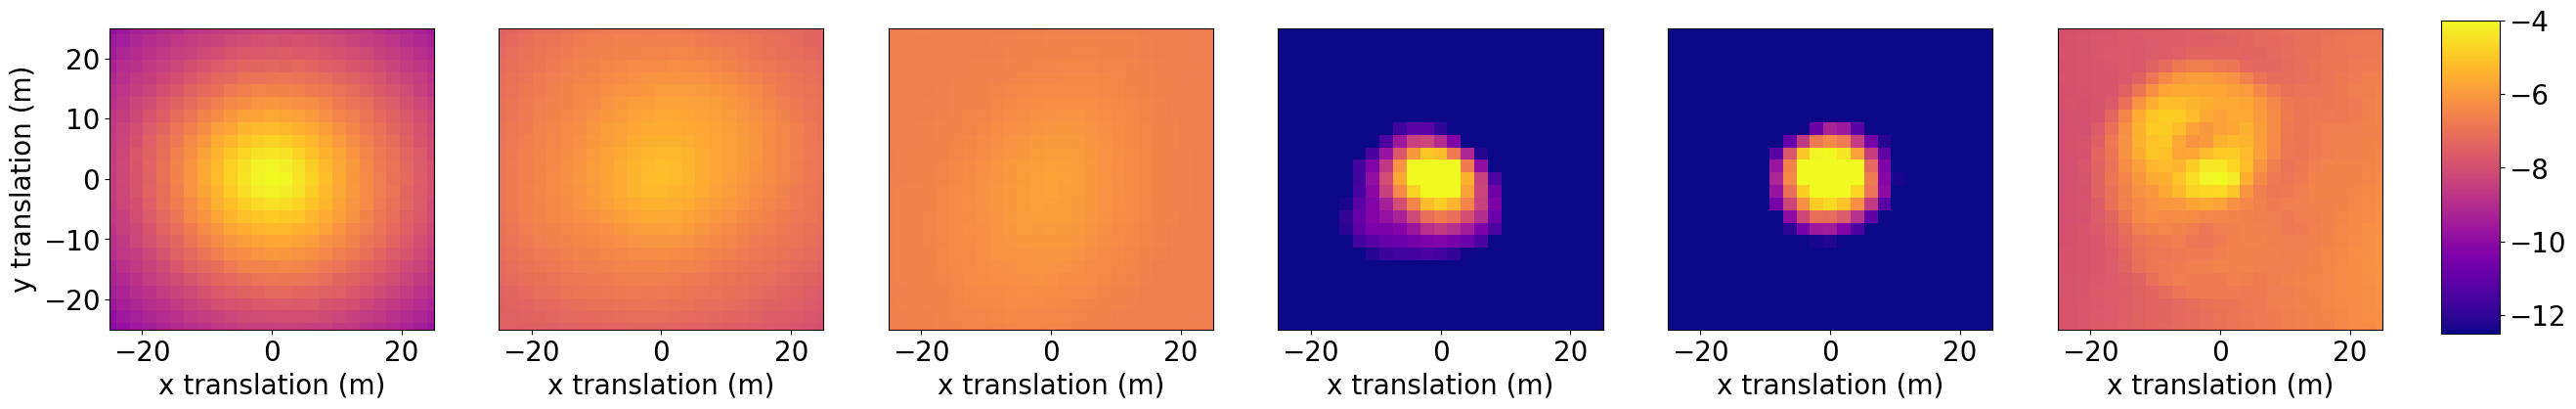

In [13]:

fig, ax = plt.subplots(1, len(frame_names), figsize=(30, 4))

for i, frame_name in enumerate(frame_names):
    x, y, score_plot_data, xy_cbar_min, xy_cbar_max = get_xy_plot_components(frame_name)
    c = ax[i].pcolormesh(x, y, score_plot_data, vmin=jnp.min(score_plot_data), vmax=jnp.max(score_plot_data))
    c.set_clim(xy_cbar_min, xy_cbar_max)
    c.set_cmap('plasma')
    # ax.set_title('Image model log probability for Y/X')
    ax[i].axis([x.min(), x.max(), y.min(), y.max()])
    # set the limits of the plot to the limits of the data
    ax[i].set_xlabel('x translation (m)')
    if not i:
        ax[i].set_ylabel('y translation (m)')
    else:
        ax[i].get_yaxis().set_ticks([])
    
    

# fig.colorbar(c, ax=ax[-1])
cb_ax = fig.add_axes([.92,.1,.02,.8])
fig.colorbar(c,orientation='vertical',cax=cb_ax)
plt.show()
fig.savefig(f'xy_posterior.png', bbox_inches = "tight")


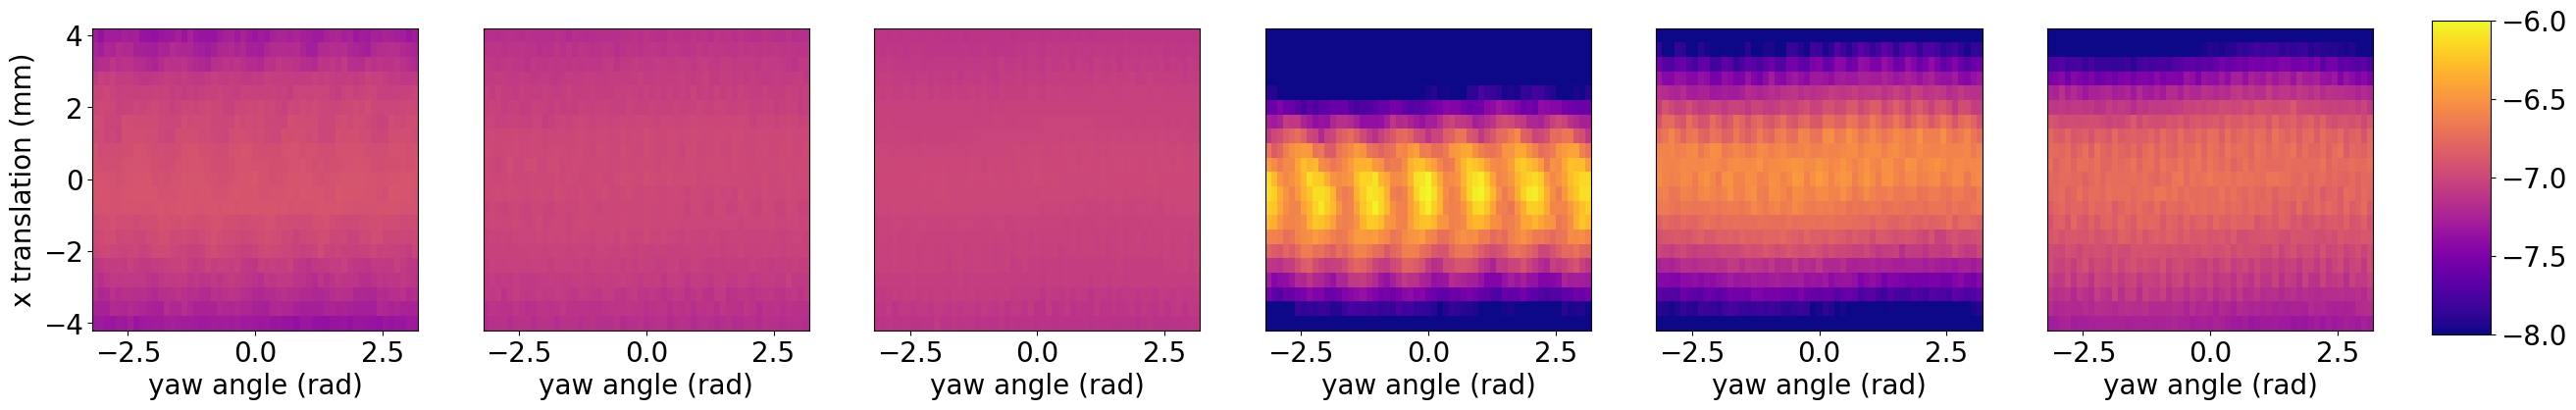

In [14]:
fig, ax = plt.subplots(1, len(frame_names), figsize=(30, 4))

for i, frame_name in enumerate(frame_names):
    theta, x, grid_scores, xtheta_cbar_min, xtheta_cbar_max = get_x_yaw_plot_components(frame_name)
    c = ax[i].pcolormesh(theta, x, grid_scores, vmin=jnp.min(grid_scores), vmax=jnp.max(grid_scores))
    c.set_clim(xtheta_cbar_min, xtheta_cbar_max)
    c.set_cmap('plasma')
    # ax.set_title('Image model log probability for Y/X')
    # set the limits of the plot to the limits of the data
    ax[i].set_xlabel('yaw angle (rad)')
    if not i:
        ax[i].set_ylabel('x translation (mm)')
    else:
        ax[i].get_yaxis().set_ticks([])
    
    

# fig.colorbar(c, ax=ax[-1])
cb_ax = fig.add_axes([.92,.1,.02,.8])
fig.colorbar(c,orientation='vertical',cax=cb_ax)
plt.show()
fig.savefig('x_yaw_posterior.png', bbox_inches = "tight")


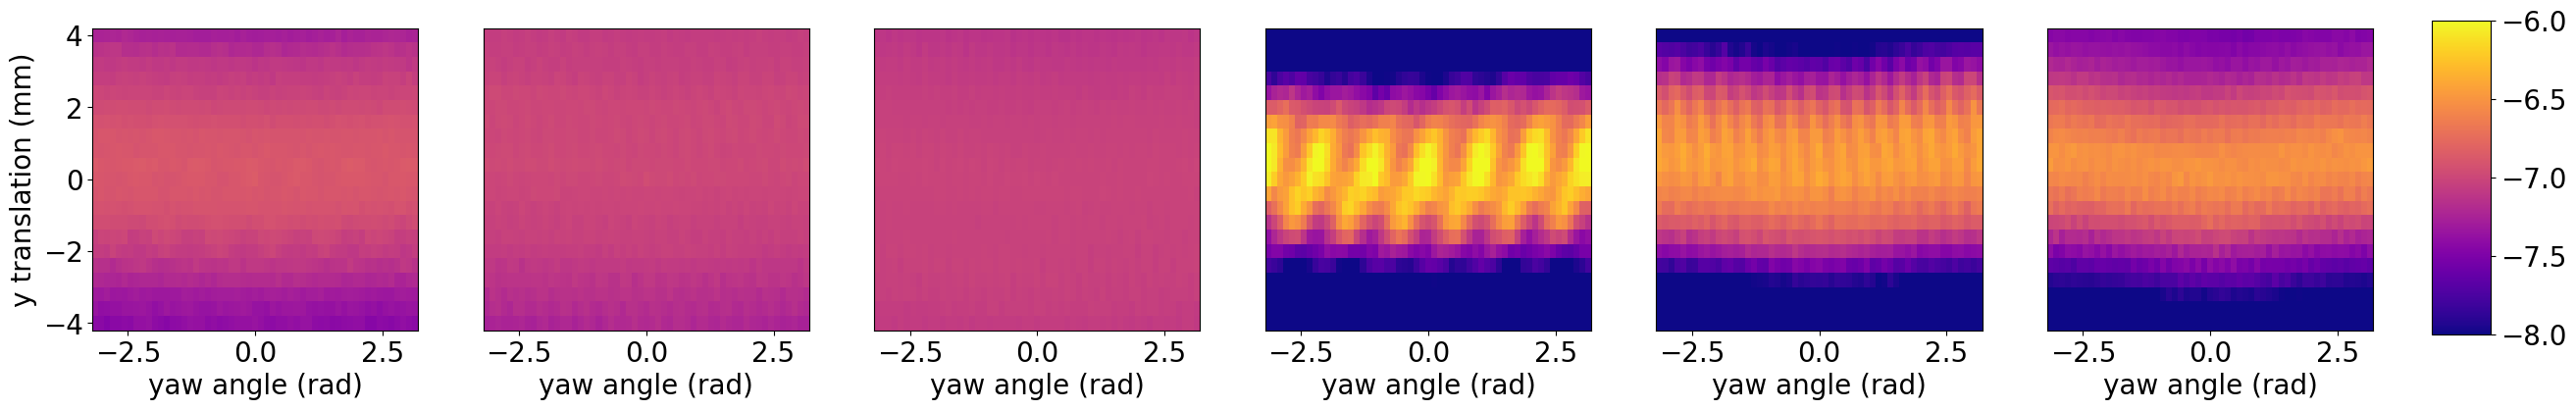

In [15]:
fig, ax = plt.subplots(1, len(frame_names), figsize=(30, 4))

for i, frame_name in enumerate(frame_names):
    theta, y, grid_scores, ytheta_cbar_min, ytheta_cbar_max = get_y_yaw_plot_components(frame_name)
    c = ax[i].pcolormesh(theta, y, grid_scores, vmin=jnp.min(grid_scores), vmax=jnp.max(grid_scores))
    c.set_clim(ytheta_cbar_min, ytheta_cbar_max)
    c.set_cmap('plasma')
    # ax.set_title('Image model log probability for Y/X')
    # set the limits of the plot to the limits of the data
    ax[i].set_xlabel('yaw angle (rad)')
    if not i:
        ax[i].set_ylabel('y translation (mm)')
    else:
        ax[i].get_yaxis().set_ticks([])
    
    

# fig.colorbar(c, ax=ax[-1])
cb_ax = fig.add_axes([.92,.1,.02,.8])
fig.colorbar(c,orientation='vertical',cax=cb_ax)
plt.show()
fig.savefig('y_yaw_posterior.png', bbox_inches = "tight")


In [16]:
frame_titles = ['$t=0$\nyellow segment', '$t=0$\npink segment', '$t=0$\nblue segment', 'yellow inspect', 'pink inspect', 'blue inspect']
hfont = {'fontname':'serif'}

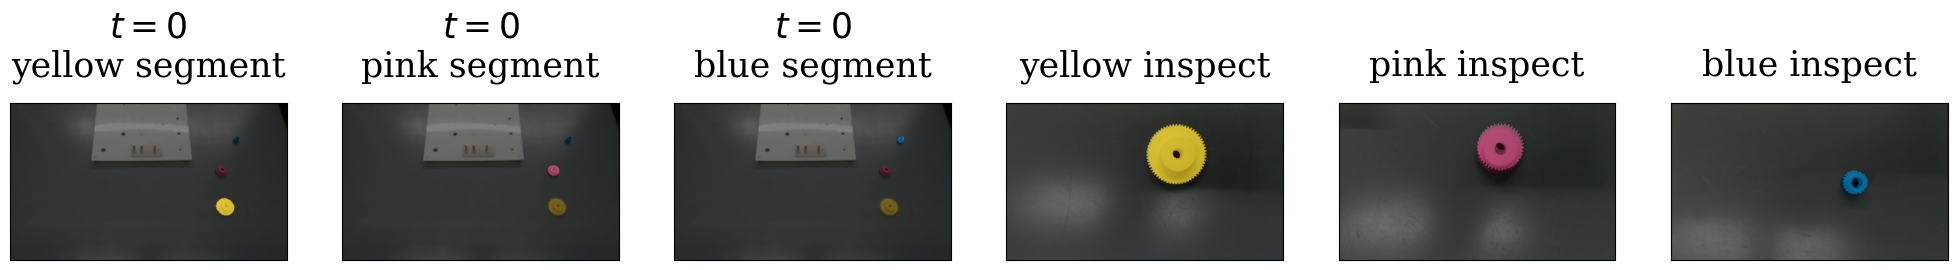

In [17]:
fig, ax = plt.subplots(1, len(frame_names), figsize=(25, 4))

for i, frame_name in enumerate(frame_names):
    trace_im = get_refined_trace_viz(frame_name, False)
    c = ax[i].imshow(trace_im)
    ax[i].set_title(frame_titles[i], fontsize=25, pad=20, **hfont)
    ax[i].get_xaxis().set_ticks([])
    ax[i].get_yaxis().set_ticks([])
fig.savefig('trace_visualizations.png', bbox_inches = "tight")

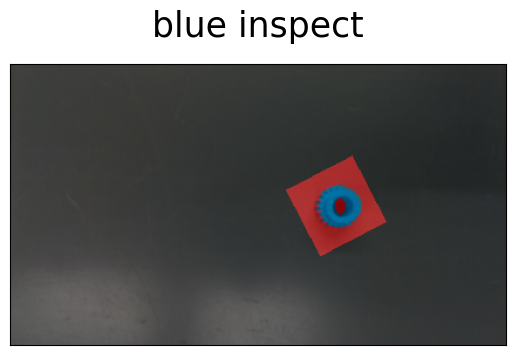

In [18]:
for i, frame_name in enumerate(frame_names):
    trace_im = get_refined_trace_viz(frame_name)
    plt.imshow(trace_im)
    plt.xticks([])
    plt.yticks([])
    plt.title(frame_titles[i], fontsize=25, pad=20)
    plt.savefig(f'trace_{frame_name}.png', bbox_inches = "tight")

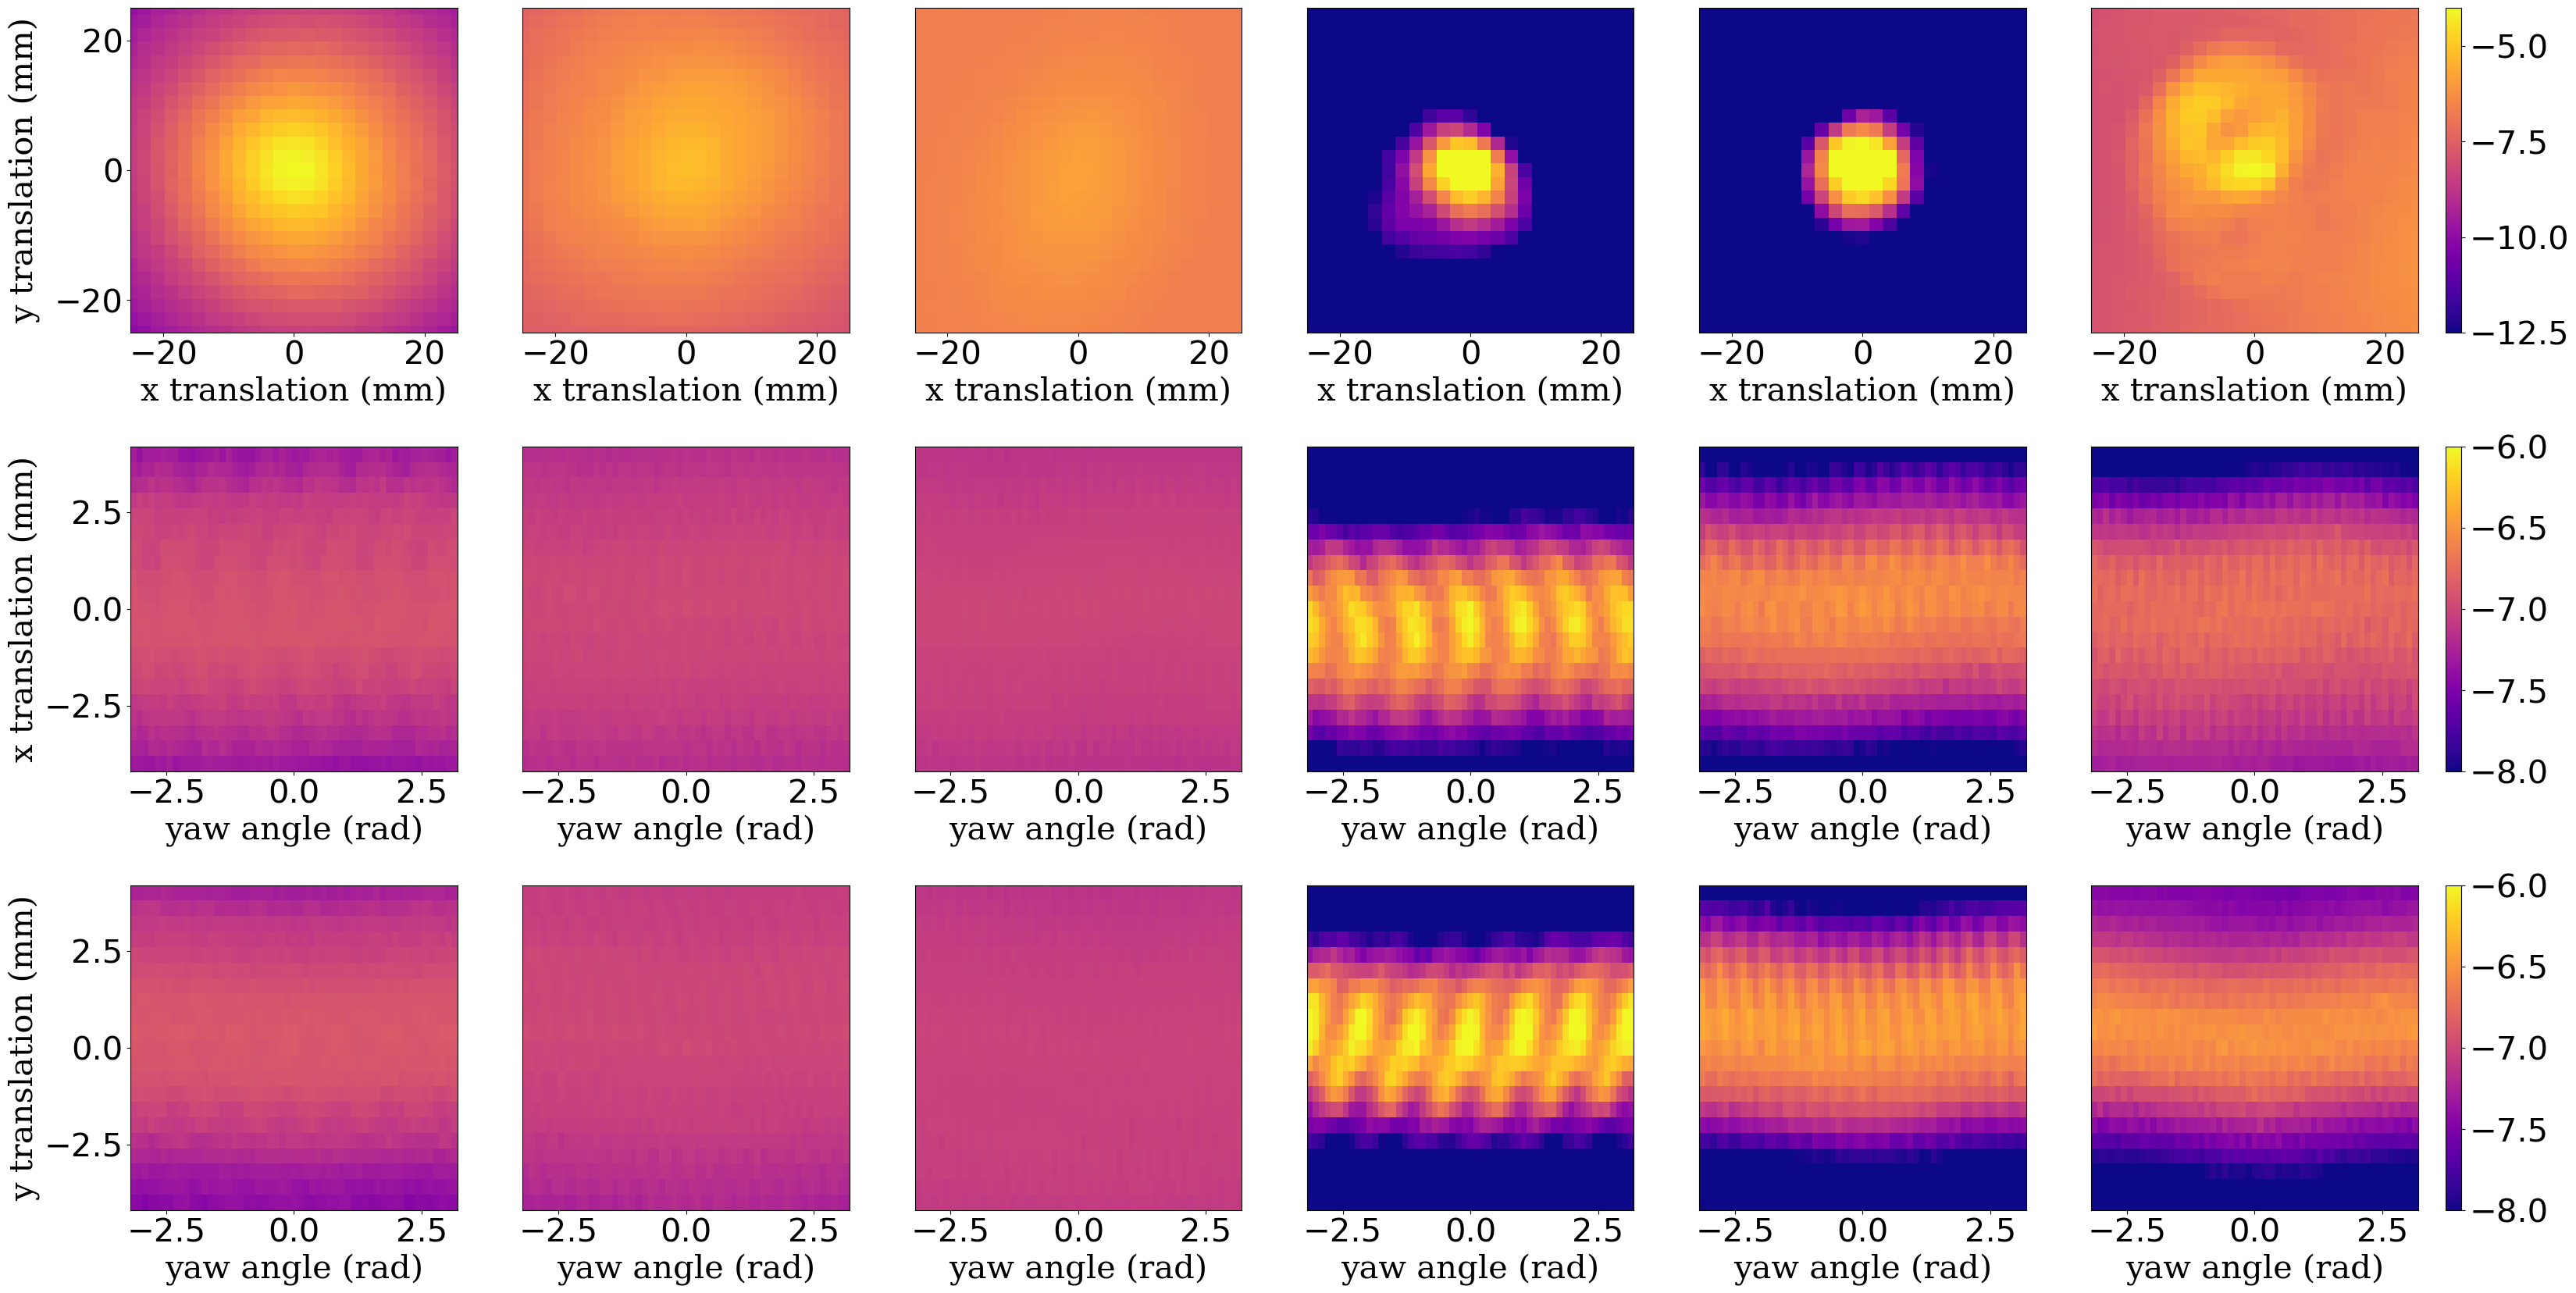

In [19]:
font = {'weight' : 'normal',
        'size'   : 30}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(3, len(frame_names), figsize=(45, 20))
plt.subplots_adjust(hspace=0.35)


for i, frame_name in enumerate(frame_names):
    x, y, score_plot_data, xy_cbar_min, xy_cbar_max = get_xy_plot_components(frame_name)
    c = ax[0,i].pcolormesh(x, y, score_plot_data, vmin=jnp.min(score_plot_data), vmax=jnp.max(score_plot_data))
    c.set_clim(xy_cbar_min, xy_cbar_max)
    c.set_cmap('plasma')
    ax[0,i].axis([x.min(), x.max(), y.min(), y.max()])
    ax[0,i].set_xlabel('x translation (mm)', **hfont)
    if not i:
        ax[0,i].set_ylabel('y translation (mm)', **hfont)
        #ax[0,i].get_yaxis().set_label_coords(-0.1,0.5)
    else:
        ax[0,i].get_yaxis().set_ticks([])
    if i == len(frame_names)-1:
        fig.colorbar(c, ax=ax[0, :], pad=0.01)

    theta, x, grid_scores, xtheta_cbar_min, xtheta_cbar_max = get_x_yaw_plot_components(frame_name)
    c = ax[1,i].pcolormesh(theta, x, grid_scores, vmin=jnp.min(grid_scores), vmax=jnp.max(grid_scores))
    c.set_clim(xtheta_cbar_min, xtheta_cbar_max)
    c.set_cmap('plasma')
    ax[1,i].set_xlabel('yaw angle (rad)', **hfont)
    if not i:
        ax[1,i].set_ylabel('x translation (mm)', **hfont)
        #ax[1,i].get_yaxis().set_label_coords(-0.1,0.5)
    else:
        ax[1,i].get_yaxis().set_ticks([])
    if i == len(frame_names)-1:
        fig.colorbar(c, ax=ax[1, :], pad=0.01)

    theta, y, grid_scores, ytheta_cbar_min, ytheta_cbar_max = get_y_yaw_plot_components(frame_name)
    c = ax[2,i].pcolormesh(theta, y, grid_scores, vmin=jnp.min(grid_scores), vmax=jnp.max(grid_scores))
    c.set_clim(ytheta_cbar_min, ytheta_cbar_max)
    c.set_cmap('plasma')
    ax[2,i].set_xlabel('yaw angle (rad)', **hfont)
    if not i:
        ax[2,i].set_ylabel('y translation (mm)', **hfont)
        #ax[2,i].get_yaxis().set_label_coords(-0.1,0.5)
    else:
        ax[2,i].get_yaxis().set_ticks([])
    if i == len(frame_names)-1:
        fig.colorbar(c, ax=ax[2, :], pad=0.01)
fig.align_labels()

fig.savefig('full_posterior_plot.png', bbox_inches = "tight")


In [20]:
tm = trimesh.load('GEABP1.0-20-10-B-10_Gear_20teeth.stl')

In [21]:
jnp.max(tm.vertices/1000,axis=0)

Array([1.0999689e-02, 1.0999689e-02, 1.3033767e-17], dtype=float32)

In [22]:
jnp.min(tm.vertices/1000,axis=0)

Array([-0.01099969, -0.01099969, -0.02      ], dtype=float32)